In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 87061347.61it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35388750.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21057428.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16799408.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Number of training samples
num_train_samples = len(train_loader.dataset)

# Number of test samples
num_test_samples = len(test_loader.dataset)

# Dimensions of the images in the dataset
image, label = next(iter(train_loader))
image_shape = image.size()[1:]

print("Number of training samples:", num_train_samples)
print("Number of test samples:", num_test_samples)
print("Dimensions of the images:", image_shape)


Number of training samples: 60000
Number of test samples: 10000
Dimensions of the images: torch.Size([1, 28, 28])


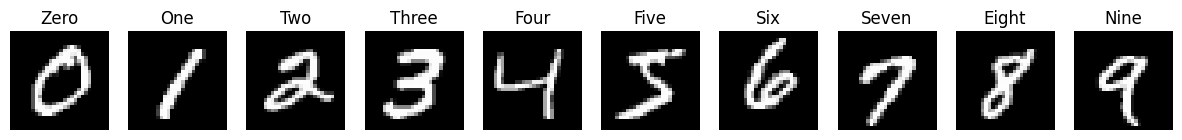

In [ ]:

# Define a dictionary to map class labels to their corresponding names
class_names = {
    0: 'Zero',
    1: 'One',
    2: 'Two',
    3: 'Three',
    4: 'Four',
    5: 'Five',
    6: 'Six',
    7: 'Seven',
    8: 'Eight',
    9: 'Nine'
}

# Function to display an example image from each class
def display_example_images(dataset, class_names):
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 3))

    for class_label, ax in enumerate(axs):
        example_image, _ = next((image, label) for image, label in dataset if label == class_label)
        ax.imshow(example_image[0], cmap='gray')
        ax.set_title(class_names[class_label])
        ax.axis('off')

    plt.show()

display_example_images(train_dataset, class_names)


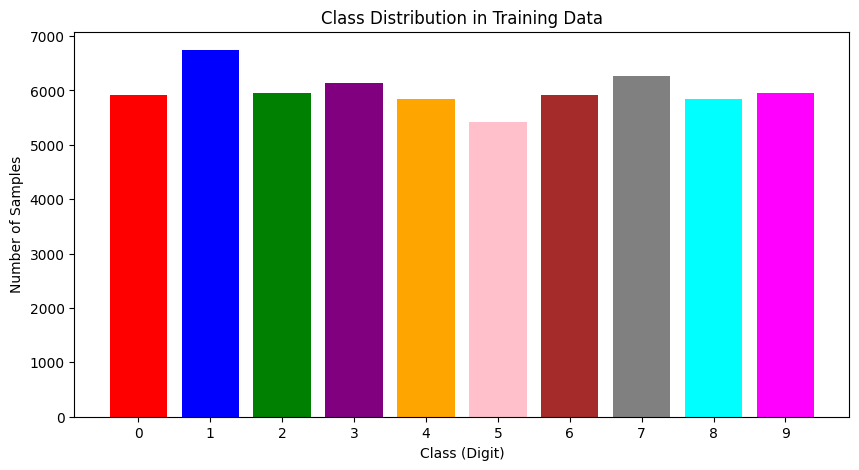

In [ ]:

# Get the labels (class IDs) for the training dataset
labels = [label for _, label in train_dataset]

# Count the number of samples for each class
class_counts = np.bincount(labels)

# Define custom colors for each bar
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# Create a bar chart (histogram) with custom colors
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_counts, tick_label=[str(i) for i in range(10)], color=colors)
plt.xlabel('Class (Digit)')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()1



In [ ]:

# Define a function to perform min-max normalization on the dataset
def min_max_normalization(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

# Apply min-max normalization to the training and test data
for i, (images, labels) in enumerate(train_loader):
  train_loader.dataset.data[i] = min_max_normalization(images[0])

for i, (images, labels) in enumerate(test_loader):
  test_loader.dataset.data[i] = min_max_normalization(images[0])


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

def train_val_split(data_loader, split_ratio=0.8):
    dataset = data_loader.dataset
    dataset_size = len(dataset)

    train_size = int(split_ratio * dataset_size)
    val_size = dataset_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=data_loader.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=data_loader.batch_size, shuffle=False)

    return train_loader, val_loader

# Define your DataLoader and split ratio (e.g., 0.8 for 80% training and 20% validation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
split_ratio = 0.8

# Split the train_loader into training and validation DataLoader objects
train_loader, val_loader = train_val_split(train_loader, split_ratio)

# Now have separate DataLoader objects for training and validation


In [ ]:

# Define the neural network model
class TeacherNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(TeacherNetwork, self).__init__()  # Corrected line
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Define the network architecture
input_size = 784  # MNIST images are 28x28 pixels
hidden1_size = 1024
hidden2_size = 512
output_size = 10  # 10 classes (digits 0-9)

# Create the neural network
teachernetwork = TeacherNetwork(input_size, hidden1_size, hidden2_size, output_size)

# Print the model architecture
print(teachernetwork)


TeacherNetwork(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


Epoch 1/20: 100%|██████████| 750/750 [00:20<00:00, 36.28it/s]


Epoch [1/20] Train Loss: 0.9906 Test Loss: 0.4887 Train Accuracy: 76.25% val Accuracy: 86.02%


Epoch 2/20: 100%|██████████| 750/750 [00:19<00:00, 38.44it/s]


Epoch [2/20] Train Loss: 0.4150 Test Loss: 0.3844 Train Accuracy: 87.96% val Accuracy: 88.53%


Epoch 3/20: 100%|██████████| 750/750 [00:19<00:00, 38.33it/s]


Epoch [3/20] Train Loss: 0.3566 Test Loss: 0.3433 Train Accuracy: 89.45% val Accuracy: 89.91%


Epoch 4/20: 100%|██████████| 750/750 [00:19<00:00, 38.64it/s]


Epoch [4/20] Train Loss: 0.3241 Test Loss: 0.3184 Train Accuracy: 90.44% val Accuracy: 90.68%


Epoch 5/20: 100%|██████████| 750/750 [00:18<00:00, 39.81it/s]


Epoch [5/20] Train Loss: 0.2996 Test Loss: 0.3005 Train Accuracy: 91.07% val Accuracy: 91.12%


Epoch 6/20: 100%|██████████| 750/750 [00:18<00:00, 39.81it/s]


Epoch [6/20] Train Loss: 0.2779 Test Loss: 0.2856 Train Accuracy: 91.62% val Accuracy: 91.67%


Epoch 7/20: 100%|██████████| 750/750 [00:19<00:00, 38.62it/s]


Epoch [7/20] Train Loss: 0.2577 Test Loss: 0.2629 Train Accuracy: 92.29% val Accuracy: 92.22%


Epoch 8/20: 100%|██████████| 750/750 [00:19<00:00, 38.23it/s]


Epoch [8/20] Train Loss: 0.2403 Test Loss: 0.2527 Train Accuracy: 92.77% val Accuracy: 92.36%


Epoch 9/20: 100%|██████████| 750/750 [00:19<00:00, 37.91it/s]


Epoch [9/20] Train Loss: 0.2238 Test Loss: 0.2347 Train Accuracy: 93.28% val Accuracy: 92.74%


Epoch 10/20: 100%|██████████| 750/750 [00:18<00:00, 39.79it/s]


Epoch [10/20] Train Loss: 0.2093 Test Loss: 0.2237 Train Accuracy: 93.73% val Accuracy: 92.94%


Epoch 11/20: 100%|██████████| 750/750 [00:18<00:00, 40.01it/s]


Epoch [11/20] Train Loss: 0.1968 Test Loss: 0.2155 Train Accuracy: 94.04% val Accuracy: 93.24%


Epoch 12/20: 100%|██████████| 750/750 [00:21<00:00, 34.87it/s]


Epoch [12/20] Train Loss: 0.1862 Test Loss: 0.2009 Train Accuracy: 94.38% val Accuracy: 93.74%


Epoch 13/20: 100%|██████████| 750/750 [00:19<00:00, 38.45it/s]


Epoch [13/20] Train Loss: 0.1760 Test Loss: 0.1968 Train Accuracy: 94.62% val Accuracy: 93.91%


Epoch 14/20: 100%|██████████| 750/750 [00:19<00:00, 38.49it/s]


Epoch [14/20] Train Loss: 0.1672 Test Loss: 0.1888 Train Accuracy: 94.89% val Accuracy: 93.97%


Epoch 15/20: 100%|██████████| 750/750 [00:19<00:00, 38.40it/s]


Epoch [15/20] Train Loss: 0.1595 Test Loss: 0.1775 Train Accuracy: 95.13% val Accuracy: 94.33%


Epoch 16/20: 100%|██████████| 750/750 [00:19<00:00, 39.41it/s]


Epoch [16/20] Train Loss: 0.1522 Test Loss: 0.1751 Train Accuracy: 95.40% val Accuracy: 94.35%


Epoch 17/20: 100%|██████████| 750/750 [00:18<00:00, 39.51it/s]


Epoch [17/20] Train Loss: 0.1458 Test Loss: 0.1723 Train Accuracy: 95.58% val Accuracy: 94.45%


Epoch 18/20: 100%|██████████| 750/750 [00:18<00:00, 40.12it/s]


Epoch [18/20] Train Loss: 0.1395 Test Loss: 0.1668 Train Accuracy: 95.77% val Accuracy: 94.59%


Epoch 19/20: 100%|██████████| 750/750 [00:19<00:00, 38.22it/s]


Epoch [19/20] Train Loss: 0.1347 Test Loss: 0.1596 Train Accuracy: 95.89% val Accuracy: 94.75%


Epoch 20/20: 100%|██████████| 750/750 [00:19<00:00, 38.63it/s]


Epoch [20/20] Train Loss: 0.1289 Test Loss: 0.1604 Train Accuracy: 96.03% val Accuracy: 94.83%


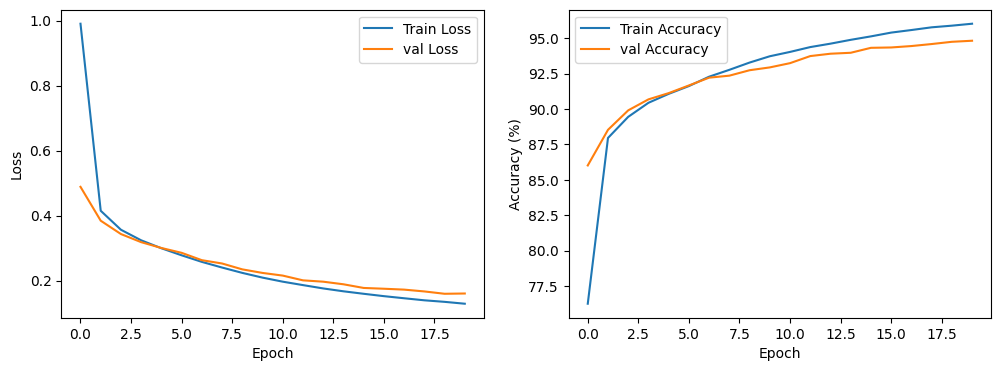

In [ ]:


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teachernetwork.parameters(), lr=0.01)

# Training settings
num_epochs = 20
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

# Training loop with tqdm progress bar
for epoch in range(num_epochs):
    teachernetwork.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = teachernetwork(inputs.view(-1, 784))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    teachernetwork.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = teachernetwork(inputs.view(-1, 784))
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(val_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} "
          f"Train Accuracy: {train_accuracy:.2f}% val Accuracy: {test_accuracy:.2f}%")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)


# Plot loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(test_accuracy_history, label='val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [ ]:
# Evaluate the network on the test data
teachernetwork.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = teachernetwork(inputs.view(-1, 784))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

print(f"Accuracy on the test data: {test_accuracy:.2f}%")


# Calculate the number of misclassifications on the test data
misclassifications = total - correct

print(f"Number of misclassifications on the test data: {misclassifications}")


Accuracy on the test data: 95.30%
Number of misclassifications on the test data: 470


In [ ]:

# Define the neural network model (Student's network)
class StudentNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(StudentNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Define the network architecture
input_size = 784  # MNIST images are 28x28 pixels
hidden1_size = 128
hidden2_size = 64
output_size = 10  # 10 classes (digits 0-9)

# Create the Student's neural network
student_model = StudentNetwork(input_size, hidden1_size, hidden2_size, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student_model.parameters(), lr=0.01)

# Training settings
num_epochs = 10
misclassifications = 0  # Counter for misclassifications
history_student=[]
# Training loop
for epoch in range(num_epochs):
    student_model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = student_model(inputs.view(-1, 784))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss/ len(train_loader):.4f}")
    student_model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = student_model(inputs.view(-1, 784))
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(train_loader)
    test_accuracy = 100 * correct_test / total_test
    history_student.append(test_accuracy)

# Evaluation on test data
student_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = student_model(inputs.view(-1, 784))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        misclassifications += (predicted != labels).sum().item()

test_accuracy = 100 * correct / total



print(f"Accuracy on the test data: {test_accuracy:.2f}%")
print(f"Number of misclassifications on the test data: {misclassifications}")


Epoch 1/10: 100%|██████████| 1875/1875 [00:17<00:00, 105.88it/s]


Epoch [1/10] Loss: 0.7704


Epoch 2/10: 100%|██████████| 1875/1875 [00:17<00:00, 105.61it/s]


Epoch [2/10] Loss: 0.3576


Epoch 3/10: 100%|██████████| 1875/1875 [00:18<00:00, 103.79it/s]


Epoch [3/10] Loss: 0.3040


Epoch 4/10: 100%|██████████| 1875/1875 [00:18<00:00, 101.57it/s]


Epoch [4/10] Loss: 0.2631


Epoch 5/10: 100%|██████████| 1875/1875 [00:18<00:00, 99.63it/s] 


Epoch [5/10] Loss: 0.2330


Epoch 6/10: 100%|██████████| 1875/1875 [00:18<00:00, 99.33it/s] 


Epoch [6/10] Loss: 0.2091


Epoch 7/10: 100%|██████████| 1875/1875 [00:18<00:00, 100.68it/s]


Epoch [7/10] Loss: 0.1907


Epoch 8/10: 100%|██████████| 1875/1875 [00:19<00:00, 97.68it/s]


Epoch [8/10] Loss: 0.1746


Epoch 9/10: 100%|██████████| 1875/1875 [00:19<00:00, 94.66it/s] 


Epoch [9/10] Loss: 0.1622


Epoch 10/10: 100%|██████████| 1875/1875 [00:18<00:00, 99.35it/s]


Epoch [10/10] Loss: 0.1516
Accuracy on the test data: 95.28%
Number of misclassifications on the test data: 472


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(teachernetwork.state_dict(), 'teacher_model.pth')


In [ ]:
# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Create and load the Teacher model
# Define the network architecture
input_size = 784  # MNIST images are 28x28 pixels
hidden1_size = 1024
hidden2_size = 512
output_size = 10  # 10 classes (digits 0-9)
teacher_model = TeacherNetwork(input_size, hidden1_size, hidden2_size, output_size)
teacher_model.load_state_dict(torch.load("teacher_model.pth"))  # Load the pre-trained Teacher model

# Define the network architecture
input_size = 784  # MNIST images are 28x28 pixels
hidden1_size = 128
hidden2_size = 64
output_size = 10  # 10 classes (digits 0-9)

# Create the Student's neural network
student_model = StudentNetwork(input_size, hidden1_size, hidden2_size, output_size)

# Loss and optimizer for Student training
criterion = nn.MSELoss()  # Use Mean Squared Error loss
optimizer = optim.SGD(student_model.parameters(), lr=0.01)

# Training settings
num_epochs = 10
misclassifications = 0  # Counter for misclassifications
history_kd=[]
# Training loop
for epoch in range(num_epochs):
    student_model.train()
    running_loss = 0.0

    for inputs, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        student_outputs = student_model(inputs.view(-1, 784))
        # Use the teacher model to obtain logits
        with torch.no_grad():
            teacher_logits = teacher_model(inputs.view(-1, 784))
        loss = criterion(student_outputs, teacher_logits)  # Use the teacher's logits for loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss/ len(train_loader):.4f}")
    student_model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, correct_labels in train_loader:
            outputs = student_model(inputs.view(-1, 784))
            labels = teacher_model(inputs.view(-1, 784))
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == correct_labels).sum().item()

    test_loss = running_loss / len(train_loader)
    test_accuracy = 100 * correct_test / total_test
    history_kd.append(test_accuracy)

# Evaluation on test data
student_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = student_model(inputs.view(-1, 784))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        misclassifications += (predicted != labels).sum().item()

test_accuracy = 100 * correct / total

print(f"Accuracy on the test data: {test_accuracy:.2f}%")
print(f"Number of misclassifications on the test data: {misclassifications}")


Epoch 1/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.87it/s]


Epoch [1/10] Loss: 2.1808


Epoch 2/10: 100%|██████████| 1875/1875 [00:21<00:00, 87.56it/s]


Epoch [2/10] Loss: 0.3415


Epoch 3/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.42it/s]


Epoch [3/10] Loss: 0.2221


Epoch 4/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.44it/s]


Epoch [4/10] Loss: 0.1770


Epoch 5/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.31it/s]


Epoch [5/10] Loss: 0.1488


Epoch 6/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.86it/s]


Epoch [6/10] Loss: 0.1321


Epoch 7/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.58it/s]


Epoch [7/10] Loss: 0.1184


Epoch 8/10: 100%|██████████| 1875/1875 [00:21<00:00, 86.13it/s]


Epoch [8/10] Loss: 0.1109


Epoch 9/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.19it/s]


Epoch [9/10] Loss: 0.1033


Epoch 10/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.08it/s]


Epoch [10/10] Loss: 0.0972
Accuracy on the test data: 94.64%
Number of misclassifications on the test data: 536


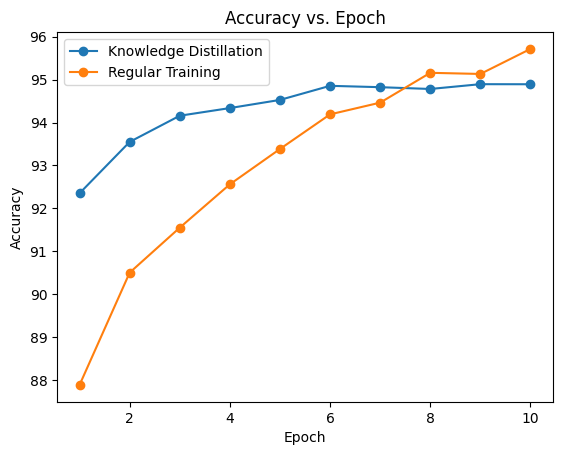

In [ ]:
epochs = list(range(1, len(history_kd) + 1))

# Plot accuracy for history_kd
plt.plot(epochs, history_kd, label='Knowledge Distillation', marker='o')

# Plot accuracy for history
plt.plot(epochs, history_student, label='Regular Training', marker='o')

# Set plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

# Show the plot
plt.show()